In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'figure.figsize': (40, 8), 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

%load_ext autoreload
%autoreload 2
    
from pympler import asizeof  # install via `pip install pympler` if not present

from smolyax import indices, nodes
from smolyax.interpolation import SmolyakBarycentricInterpolator

def target_f(x, theta=2., r=2.) :
    return 1/(1+ theta * np.sum(x * (np.arange(x.shape[-1]) + 2)**(-r), axis=-1))

# Assymptotic memory consumption of the interpolation operator 

The memory required for the Smolyak interpolation operator is dominated by the tensors that store function evaluations of the individual tensor product interpolants. This notebook compares the theoretical size of these tensors to the actual size of a corresponding `SmolyakBarycentricInterpolator` instance. The results below indicate that, asymptotically as the number $n$ of interpolation nodes increases, the memory requirements of the `SmolyakBarycentricInterpolator` class approach the theoretical lower bound—i.e., the combined tensor size—up to a moderate constant factor.

In [2]:
to_GB = 1024**(-3)

def size_tensors(k, t, d) :
    indxs = indices.indexset(k, t)
    size = 0
    for nu in indxs :
        zeta = indices.smolyak_coefficient(k, d, t - np.sum([k[j]*nu_j for j,nu_j in nu]), 0)
        if zeta != 0 :
            size += np.prod([si + 1 for _, si in nu])
    return size * np.dtype(np.float64).itemsize * to_GB

def size_interpolator(node_gen, k, t) :
    ip = SmolyakBarycentricInterpolator(node_gen=node_gen, k=k, d_out=1, t=t, f=target_f)
    return asizeof.asizeof(ip) * to_GB

In [3]:
n_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
results = np.zeros((len(n_list), 2))

d = 200
for i, n in enumerate(n_list) :
    node_gen = nodes.Leja(dim=d)
    k = [np.log((2+j)/np.log(2)) for j in range(d)]
    t = indices.find_approximate_threshold(k, n, nested=node_gen.is_nested)
    
    results[i][0] = size_tensors(k, t, d)
    results[i][1] = size_interpolator(node_gen, k, t)

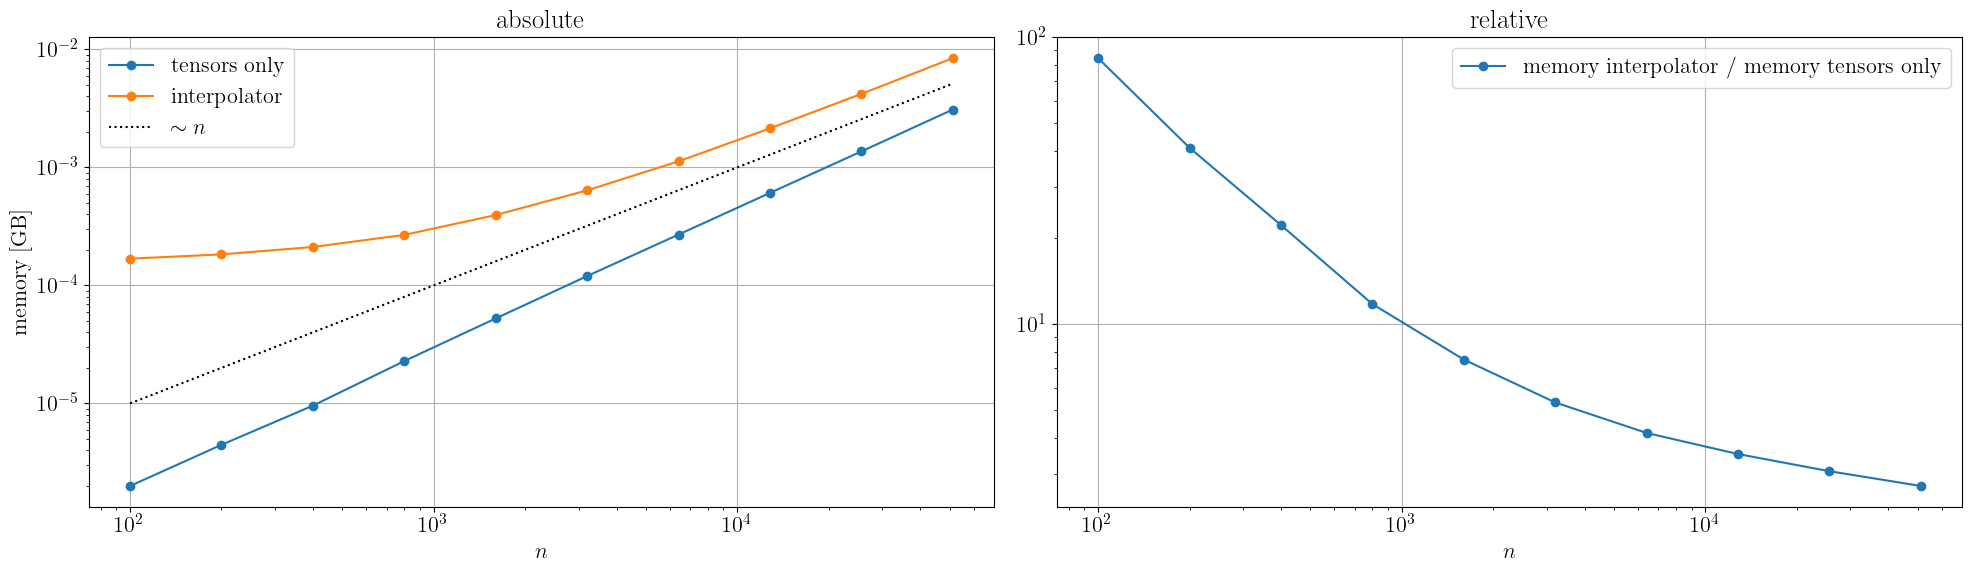

In [9]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
axs[0].loglog(n_list, results[:, 0], marker='o', label='tensors only')
axs[0].loglog(n_list, results[:, 1], marker='o', label='interpolator')
axs[0].loglog(n_list, np.array(n_list) * 1e-7, 'k:', label=r'$\sim n$')
axs[1].loglog(n_list, results[:, 1]/results[:, 0], marker='o', label='memory interpolator / memory tensors only')
for ax, title in zip(axs, ['absolute', 'relative', ]): ax.set_xlabel(r'$n$'); ax.grid(); ax.set_title(title); ax.legend()
axs[0].set_ylabel('memory [GB]')
plt.tight_layout()